# Analysis of survival data using causallib

This notebook shows how to run the survival analysis steps for the epilepsy experiments for a single drug, using  causallib. The steps required are loading the data, using Trimming to perform positivity violation identificationa and filtering, fitting a survival model, evaluating the models' performance, plotting Kaplan-Meir curves, and computing logrank test p-values on the curves data.

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt

from causallib.survival import WeightedSurvival
from causallib.estimation import IPW
from causallib.metrics.weight_metrics import calculate_covariate_balance
from causallib.evaluation import evaluate

from positivity_trimming import Trimming
#from positivity import Trimming

# Genrate random data for example

Here we will generate random data for X, a, t, y, for showing how these csv files should look like. When you want to run this on real data, you should replace the file names to the file names with the actual data and not use the example files that are generaed here.

In [2]:
feature_file_example = pd.DataFrame(np.random.randint(0,100,size=(100, 3)), columns=['feature_A', 'feature_B', 'feature_C'])
feature_file_example.insert(loc=0, column='row_ids', value=np.arange(100)) 
feature_file_example = feature_file_example.set_index('row_ids')
feature_file_example.to_csv('features_file.csv')

treatment = [0]*50 + [1]*50
random.shuffle(treatment)
treatment_file_example = pd.Series(index = feature_file_example.index, data = treatment)
treatment_file_example.to_csv('treatment_file.csv')

outcome = [0]*50 + [1]*50
random.shuffle(treatment)
outcome_file_example = pd.Series(index = feature_file_example.index, data = treatment)
outcome_file_example.to_csv('outcome_file.csv')

time_duration = np.random.randint(0,1000,size = 100)
time_file_example = pd.Series(index = feature_file_example.index, data = time_duration)
time_file_example.to_csv('time_file.csv')


## Load data

We load the sample data created here, to use on real data, change thefile paths to the ones holding the correct data. The first column in each of the files needs to contain the ids of the patients (or some other identifier, that is consistent across all the 4 files). 
- The features file should have the ids and all the features to use. 
- The treatment file should contain the ids and a binary column describing treatment assignment (0 for control, 1 for treated)
- The time duration file should contain the ids and the number of days from index date (per patient) to an event (either outcome event or censoring event)
- The outcome file should contain the ids and a binary variable (0 or 1) indicating whether the event was an outcome event (1) or a censoring event (0)

In [3]:
treatment_assignment_file = 'treatment_file.csv' # Path to treatment assignment file
features_file = 'features_file.csv' # Path to features file
time_durations_file = 'time_file.csv' # Path to time durations file
outcome_type_file = 'outcome_file.csv' # Path to outcome type file

X = pd.read_csv(features_file, index_col=0, squeeze=True)
a = pd.read_csv(treatment_assignment_file, index_col=0, squeeze=True)
t = pd.read_csv(time_durations_file, index_col=0, squeeze=True)
y = pd.read_csv(outcome_type_file, index_col=0, squeeze=True)

/tmp/ipykernel_948792/3039477847.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  X = pd.read_csv(features_file, index_col=0, squeeze=True)
/tmp/ipykernel_948792/3039477847.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  a = pd.read_csv(treatment_assignment_file, index_col=0, squeeze=True)
/tmp/ipykernel_948792/3039477847.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  t = pd.read_csv(time_durations_file, index_col=0, squeeze=True)
/tmp/ipykernel_948792/3039477847.py:9: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y = pd.read_csv(outcome_type_file, index_col

# Functions for positivity filtering and model fitting

In [4]:
lr_kwargs = dict(penalty="none", max_iter=500)

def filter_positivity(X,a,t,y):
    positivity_filter = Trimming(learner=LogisticRegression(**lr_kwargs), threshold="auto")
    positivity_idx = positivity_filter.fit_predict(X, a)
    X = X.loc[positivity_idx]
    a = a.loc[positivity_idx]
    t = t.loc[positivity_idx]
    y = t.loc[positivity_idx]
    return X,a,t,y

def fit_model(X,a,t,y):
    ipw_surv = WeightedSurvival(IPW(LogisticRegression(**lr_kwargs)))
    ipw_surv = ipw_surv.fit(X, a, t, y)
    return ipw_surv

# Positivity filtering and fitting of survival model

The first step of the analysis is to filter out positiviry violations, and then fit the survival model on the filtered data

In [5]:
num_patients_before_positivity = X.shape[0]
X,a,t,y = filter_positivity(X,a,t,y)
num_patients_after_positivity = X.shape[0]
ipw_surv = fit_model(X,a,t,y)
print(f'num patients before positivity filterng = {num_patients_before_positivity}, after positivity = {num_patients_after_positivity}')

num patients before positivity filterng = 100, after positivity = 100


# Evaluation of the model fit and balancing of covariates

In [6]:
def count_imbalanced_features_error(
    X, a, sample_weight, threshold=0.1, fraction=True, **kwargs
) -> float:
    asmds = calculate_covariate_balance(X, a, sample_weight, metric="abs_smd")
    weighted_asmds = asmds["weighted"]
    is_violating = weighted_asmds > threshold
    score = sum(is_violating)
    if fraction:
        score /= is_violating.shape[0]
    return score

In [7]:
w = ipw_surv.weight_model.compute_weights(X, a)
num_imbalanced = count_imbalanced_features_error(X,a,w, fraction=False)
print(f'number of imbalanced features: {num_imbalanced}')

number of imbalanced features: 0


{'train': {'covariate_balance_love': <AxesSubplot: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>,
  'calibration': <AxesSubplot: title={'center': 'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'covariate_balance_slope': <AxesSubplot: ylabel='Absolute Standard Mean Difference'>,
  'weight_distribution': <AxesSubplot: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'pr_curve': <AxesSubplot: title={'center': 'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'roc_curve': <AxesSubplot: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>}}

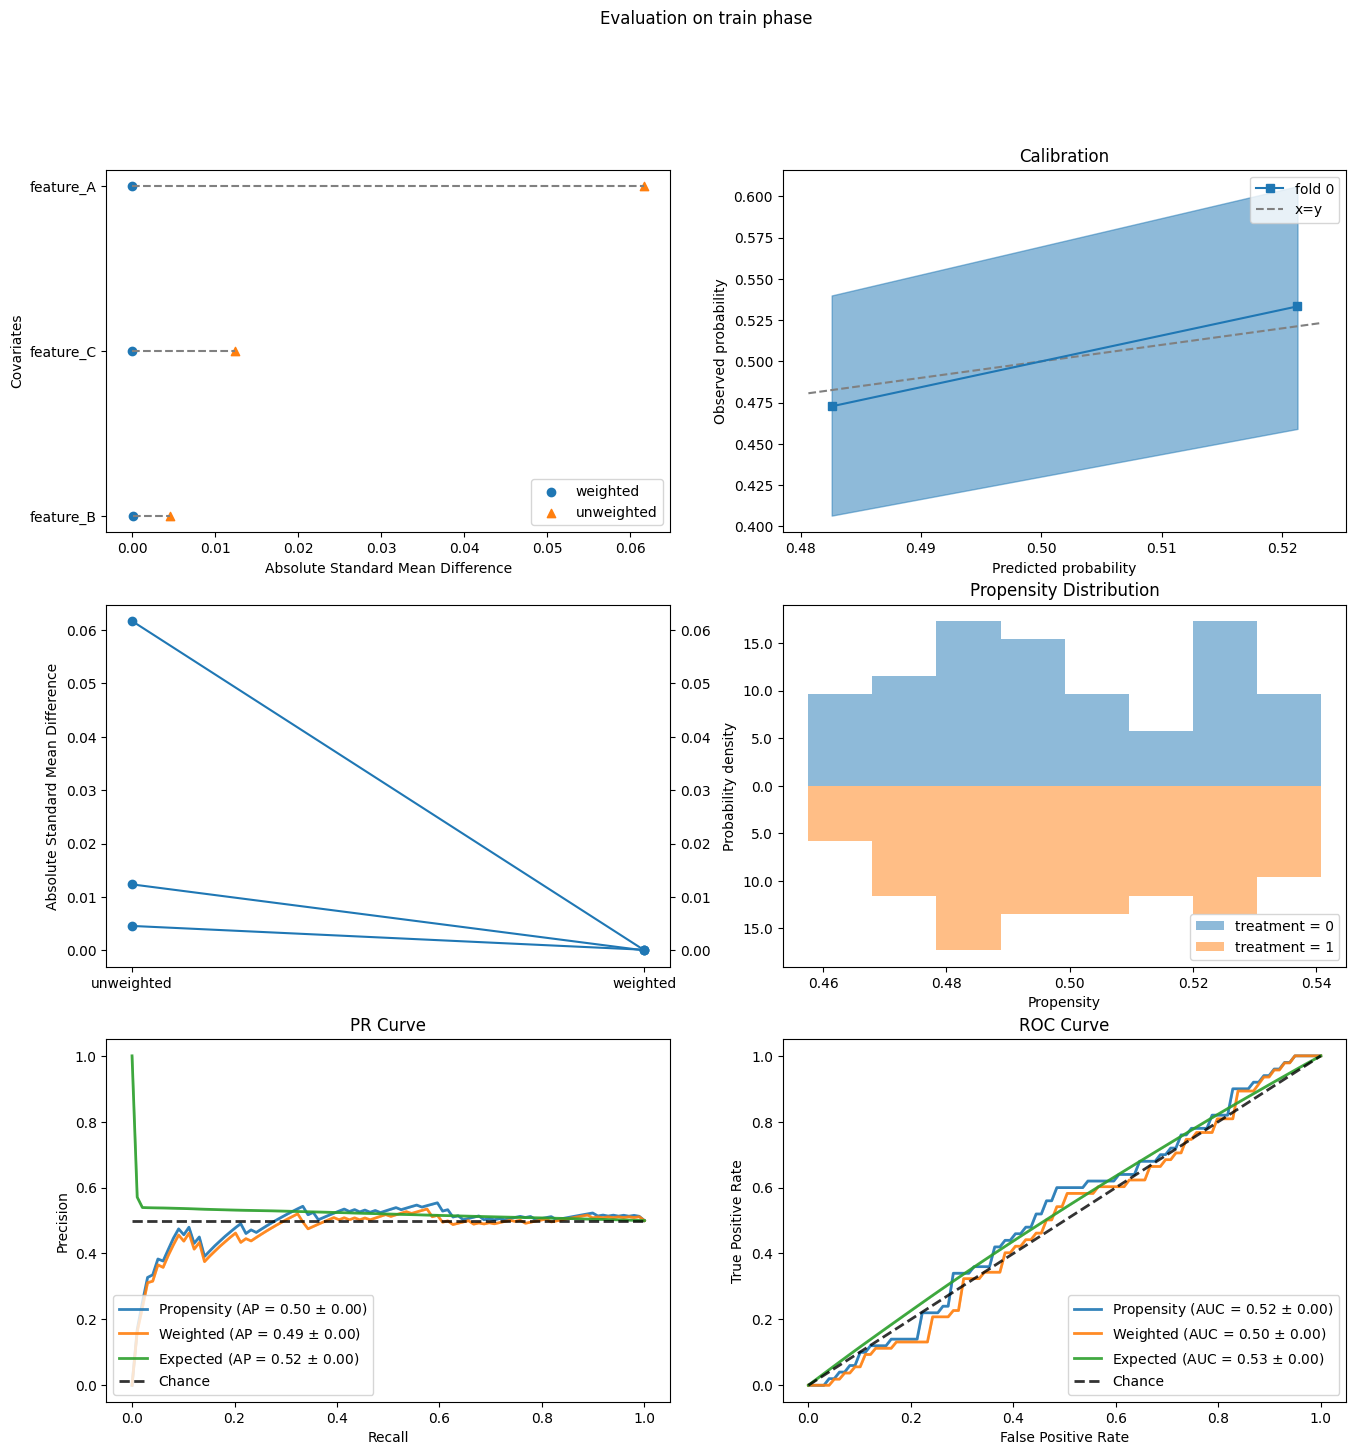

In [8]:
evaluation_results = evaluate(ipw_surv.weight_model, X, a, y)
evaluation_results.plot_all()

## Weighted Kaplan Meier curves


In [9]:
def run_experiment(X, a, t, y, surv_model, fit_model = False, filter_positivity=False):
    if filter_positivity: #use True is the data was not already filtered for positivity violations
        X,a,t,y = filter_positivity(X,a,t,y)
    if fit_model: #use True is the model was not already fitted
        surv_model = fit_model(X,a,t,y)

    t_min = t.min()  
    t_max = t.max()
    potential_outcomes_estimate_df = surv_model.estimate_population_outcome(
            X, a, t, y,
            timeline_start=t_min,
            timeline_end=t_max,
        )
    return potential_outcomes_estimate_df

def plot_survival_curves(treatment_name, control_name, potential_outcomes_estimate_df, ax=None):
    if ax is None:
        ax = plt.gca()
    treatment_survival=potential_outcomes_estimate_df[1].to_list()
    control_survival=potential_outcomes_estimate_df[0].to_list()
    timeline=potential_outcomes_estimate_df.index.to_list()
    
    ax.plot(timeline, control_survival, label=control_name)
    ax.plot(timeline, treatment_survival, label=treatment_name)
    ax.legend()
    return ax

<AxesSubplot: >

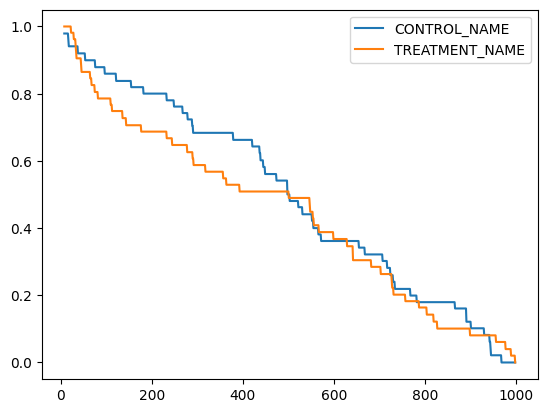

In [10]:
# We use fit_model=False and filter_positicity=False since the data after it was already filtered for positivity and the survival model was already fitted
potential_outcomes_estimate_df = run_experiment(X,a,t,y, ipw_surv, fit_model=False, filter_positivity=False)
treatment_name = 'TREATMENT_NAME' # i.e, dexamethasone (or other drug used)
control_name = 'CONTROL_NAME' # i.e, no_dexamethasone (or other drug used)
plot_survival_curves(treatment_name, control_name, potential_outcomes_estimate_df)

### Log rank test for the weighted survival data

In [11]:
def cut_data_to_timeframe(a,t,y,w, start_time=None, end_time=None):
    from copy import deepcopy
    t_cut = deepcopy(t)
    a_cut = deepcopy(a)
    y_cut = deepcopy(y)
    w_cut = deepcopy(w)
    if start_time is not None:
        t_cut = t_cut[t_cut >= start_time]
        a_cut = a_cut.loc[t_cut.index]
        y_cut = y_cut.loc[t_cut.index]
        w_cut = w_cut.loc[t_cut.index]
    if end_time is not None:
        t_cut = t_cut[t_cut <= end_time]
        a_cut = a_cut.loc[t_cut.index]
        y_cut = y_cut.loc[t_cut.index]
        w_cut = w_cut.loc[t_cut.index]
    return a_cut,t_cut,y_cut,w_cut

def logrank(a, t, y, sample_weights=None):
    untreated = a == 0
    durations_A = t[untreated]
    durations_B = t[~untreated]
    event_observed_A = y[untreated]
    event_observed_B = y[~untreated]
    if sample_weights is not None:
        weights_A = sample_weights[untreated]
        weights_B = sample_weights[~untreated]
    else:
        weights_A, weights_B = None, None
    res = logrank_test(
        durations_A, durations_B,
        event_observed_A, event_observed_B,
        weights_A=weights_A, weights_B=weights_B,
    )
    p_value = res.p_value
    return p_value

In [12]:
w = ipw_surv.weight_model.compute_weights(X, a)

start_time = None # set to int value if want to compute logrank test starting from some number of days post index date
end_time = None # set to int value if want to look at timeline ending before end of data
a_cut,t_cut,y_cut,w_cut = cut_data_to_timeframe(a,t,y,w, start_time=start_time, end_time=end_time)
log_rank_p_val_all = logrank(a_cut,t_cut,y_cut, sample_weights=w_cut)

end_time = 365
a_cut,t_cut,y_cut,w_cut = cut_data_to_timeframe(a,t,y,w, start_time=start_time, end_time=end_time)
log_rank_p_val_start = logrank(a_cut,t_cut,y_cut, sample_weights=w_cut)

end_time = None
start_time = 365
a_cut,t_cut,y_cut,w_cut = cut_data_to_timeframe(a,t,y,w, start_time=start_time, end_time=end_time)
log_rank_p_val_end = logrank(a_cut, t_cut, y_cut, sample_weights=w_cut)

print(f'log rank p-value, entire timeline = {log_rank_p_val_all}')
print(f'log rank p-value, time 0 to 365 = {log_rank_p_val_start}')
print(f'log rank p-value, time 365 to end = {log_rank_p_val_end}')

log rank p-value, entire timeline = 0.9757471632062794
log rank p-value, time 0 to 365 = 0.3434475451027331
log rank p-value, time 365 to end = 0.07296366620494163


/home/lszlak/alz_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
